# Anomaly Detection Algorithms - Comparative Understanding

In this notebook we investigate the performance of four anomaly detection algorithms. We will focus on their performance and time-complexity.

- Local Outlier Factor
- Isolation Forest
- Fast-MCD (Minimum Covariance Determinant)
- Gaussian Mixture Model (GMM)



## Dataset

We use a credit card transaction dataset. 
https://www.kaggle.com/mlg-ulb/creditcardfraud

It contains 284,807 transactions of which 492 transactions are fraudulent. We consider the fraudulent transactions as anomalies, and use the three algorithms to identification.  The dataset is **highly unbalanced**, the positive class (frauds) account for 0.172% of all transactions.

The dataset presents transactions that occurred in two days in September 2013 by european cardholders


### Features
The dataset contains only **numerical input** variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features are not provided. Features V1, V2, ... V28 are the principal components obtained with PCA.

The only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. We use this variable to evaluate the performance of the anomaly detection algorithms.




## Evaluation 

We divide the dataset into training and test set, then train the anomaly detection model using the training set. Finally, we use the test dataset to evaluate the performance of the model.

Performance evaluation of an anomaly detection algorithm is tricky. Because it is unsupervised learning in which we don't usually have the labels of the data.

However, when labeled data are available, we can use **Receiver Operating Characteristic (ROC) curve** to compare the performance of unsupervised anomaly detection algorithms. More specufically, we use the **Area Under Curve (AUC)** score to measure the performance.

AUC of a classifier is equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance. Note in our anomaly detection problem, an outlier/anomaly has a higher score, as compared to a normal data point. 

- Thus, a high AUC score indicates that the anomaly detection algorithm ranks an outlier data point with high probability.

More specifically, if we randomly pick a “valid” and an “fraudulent” user activity from our test set, the “fraudulent” one will have a **higher anomaly score with a probability that equals the AUC**. This is essential in our product, since we want to make sure that abnormal events get highlighted with an anomaly score larger than that of normal events.

The AUC value of an anomaly scorer’s performance ranges from 0 to 1. 
- An AUC of 1 indicates a flawless anomaly scorer that perfectly separates the two classes (“valid” and “fraudulent”). 
- If the AUC is below 1, that means that some “valid” events have larger scores than “fraudulent” ones do. 


In [1]:
import warnings
from time import time
import pandas as pd
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture

## Load the Data

In [2]:
df = pd.read_csv('/Users/hasan/datasets/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (284807, 31)
No. of Rows: 284807
No. of Columns: 31


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Missing Value

The count of each column is 28481 which suggests there are no missing values.

## Data Distribution

We see that the data is heavily skewed.

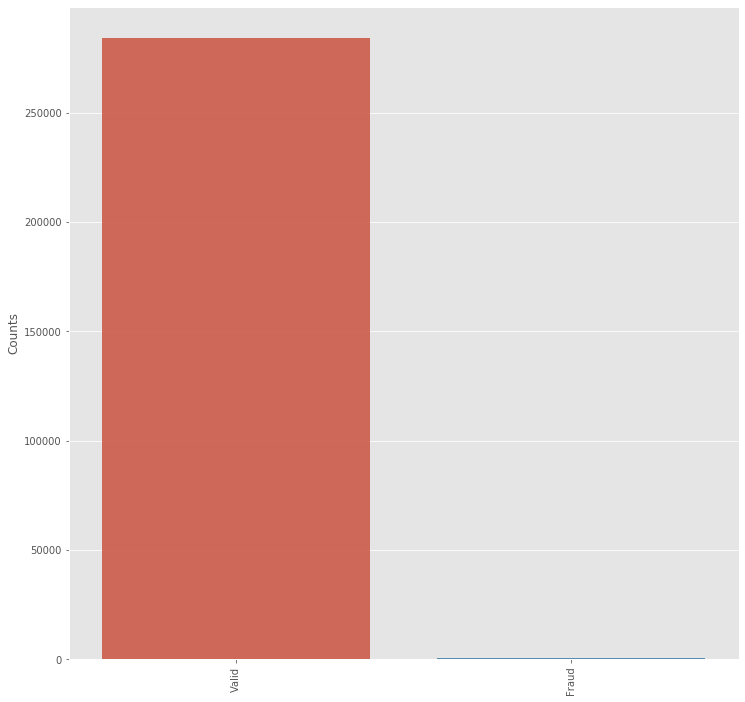

In [5]:
df['label'] = df['Class'].map({1: 'Fraud', 0: 'Valid'})

label_counts = df.label.value_counts()

plt.figure(figsize = (12,12))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Correlation Analysis

The correlation matrix (below) shows that none of the V1 to V28 PCA components have any correlation to each other. 

- ‘Class’ is less correlated with ‘Amount’ and ‘Time’ which suggests it is hard to predict whether transaction is fraudulent or not from ‘Amount’ and ‘Time’ details of transaction.

- ‘Class’ is negatively correlated with ‘V3’, ‘V7’, ‘V10’, ‘V12’, ‘V14’, ‘V17’ and positively correlated with ‘V2’, ‘V4’, ‘V11’. 

- The other correlations are relatively small.

There are **no significant correlations** between the reduced features (‘V1’ to V’28'). Therefore we don’t drop any of the columns as they are fairly unrelated to each other.

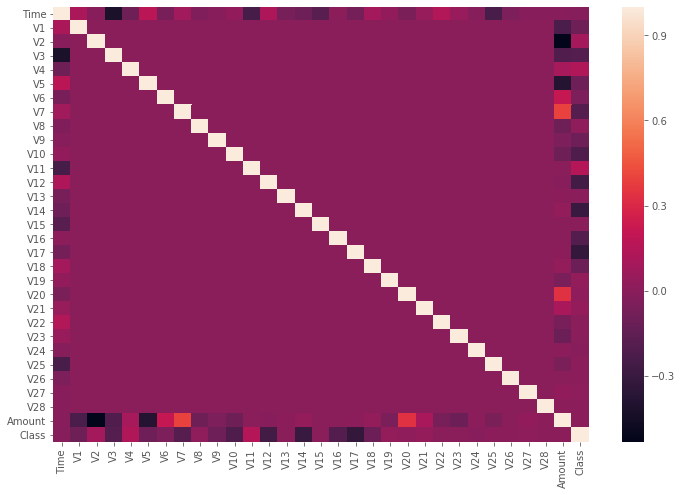

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr()) # Heatmap of correlation between columns of ‘df’.
plt.show()

## Compute Fraction of Outliers (Contamination)

In [7]:
fraud = df[df['Class'] == 1] # Number of fraudulent transactions
valid = df[df['Class'] == 0] # Number of valid transactions
outlier_fraction = len(fraud)/float(len(valid))

print("Outlier Fraction: %f" % outlier_fraction)

Outlier Fraction: 0.001730


## Create Data Matrix X and label vector y

In [8]:
y = df['Class']
X = df.drop(['Class', 'label'], axis=1)

## Create Train and Test Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into random train and test subsets.

For the reproducibility of the results, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function.

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Local Outlier Factor

We use Scikit-Learn's LocalOutlierFactor model for performing anomaly detection: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

We need to be careful about setting the following two attributes.
- n_neighbors (usually denoted by $k$)
- contamination (fraction of anomalies in the dataset)

Below we provide a brief guideline to determine optimal values for these two parameters.


        contamination:
It represents the proportion of outliers in the data set. It is used when fitting to define the threshold on the scores of the samples.
- If ‘auto’, the threshold is determined as in the original paper.
- If float, the contamination should be in the range [0, 0.5].

**We use 0.1 to set the contamination value for all experiments. The rationale is that it provides the highest AUC score on test data.**


        n_neighbors:

Choosing the optimal $k$ is tricky.

Ideally, we should use a range of $k$ to compute the LOF values of a data point and take the maximum LOF value from the range. We do this because we don't usually have the label of the data.

**Since the credit card dataset contains labels (fraud/normal), we choose a value of $k$ that gives the highest AUC on the test dataset.**

In [10]:
%%time
clf_lof=LocalOutlierFactor(n_neighbors=2, algorithm='auto', leaf_size=20, 
                           metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=-1)

CPU times: user 57 µs, sys: 1e+03 ns, total: 58 µs
Wall time: 66 µs


## Local Outlier Factor: Evaluate Model Performance

We use the "fit_predict" method of the LocalOutlierFactor model to generate labels for each data point.

- +1: inlier
- -1: outlier

LOF: Running Time = 0.747s

Number of Errors:  8545
Accuracy Score:  0.8999918074037663
AUC Score:  0.7003147455660145


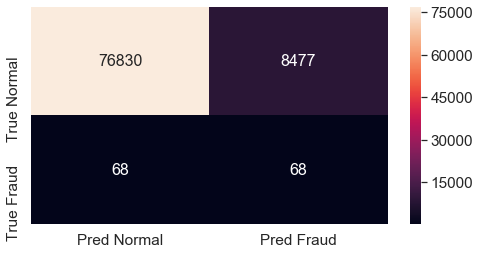

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85307
           1       0.01      0.50      0.02       136

    accuracy                           0.90     85443
   macro avg       0.50      0.70      0.48     85443
weighted avg       1.00      0.90      0.95     85443



In [11]:
t0 = time()
y_test_pred_lof = clf_lof.fit_predict(X_test)

time_lof = time() - t0

print("LOF: Running Time = %0.3fs" % time_lof)

#print(y_test_pred_lof)

neg_lof_scores = clf_lof.negative_outlier_factor_
#print(neg_lof_scores)


# Create a copy of the predictions
y_test_pred_lof_class=y_test_pred_lof.copy()


# Re-Label fraudulent transactions with 1 and valid transaction with 0
y_test_pred_lof_class[y_test_pred_lof==-1]=1  # Fraudulent transactions are labelled as 1.
y_test_pred_lof_class[y_test_pred_lof==1]=0   # Valid transactions are labelled as 0.


# Compute total number of errors 
errors_lof = (y_test_pred_lof_class != y_test).sum() 
print("\nNumber of Errors: ", errors_lof)

print("Accuracy Score: ", accuracy_score(y_test_pred_lof_class, y_test))

auc_lof = roc_auc_score(y_test, y_test_pred_lof_class)

print("AUC Score: ", auc_lof)


cf_lof = confusion_matrix(y_test, y_test_pred_lof_class)

df_cm = pd.DataFrame(cf_lof, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.show()

print(classification_report(y_test, y_test_pred_lof_class))

## Isolation Forest

We use Scikit-Learn's IsolationForest model for performing anomaly detection.
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.decision_function

In [12]:
%time

iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1,
                    max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42, behaviour="new")


t0 = time()
iso_forest.fit(X_train)

time_iso_forest = time() - t0

print("Isolation Forest: Running Time = %0.3fs" % time_iso_forest)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


Isolation Forest: Running Time = 10.828s


## Isolation Forest: Evaluate Model Performance

We use the "predict" method of the IsolationForest model to generate labels for each data point.
- +1: inlier
- -1: outlier



Number of Errors:  8431
Accuracy Score:  0.9013260302189764
AUC Score:  0.9028664377587109


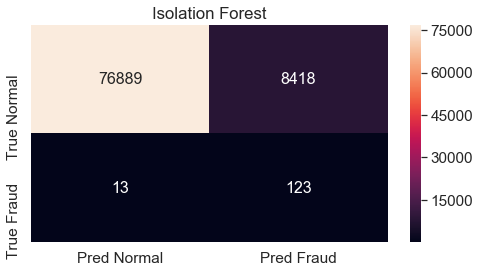

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85307
           1       0.01      0.90      0.03       136

    accuracy                           0.90     85443
   macro avg       0.51      0.90      0.49     85443
weighted avg       1.00      0.90      0.95     85443

CPU times: user 3.1 s, sys: 332 ms, total: 3.43 s
Wall time: 3.43 s


In [13]:
%%time

y_test_pred_isof = iso_forest.predict(X_test)


# Create a copy of the predictions
y_test_pred_isof_class=y_test_pred_isof.copy()


# Re-Label fraudulent transactions with 1 and valid transaction with 0
y_test_pred_isof_class[y_test_pred_isof==-1]=1 # Fraudulent transactions are labelled as 1.
y_test_pred_isof_class[y_test_pred_isof==1]=0 # Valid transactions are labelled as 0.

# Compute total number of errors 
errors_isof = (y_test_pred_isof_class != y_test).sum() 
print("\nNumber of Errors: ", errors_isof)

print("Accuracy Score: ", accuracy_score(y_test_pred_isof_class, y_test))

auc_iso_forest = roc_auc_score(y_test, y_test_pred_isof_class)

print("AUC Score: ", auc_iso_forest)


cf_isof = confusion_matrix(y_test, y_test_pred_isof_class)

df_cm = pd.DataFrame(cf_isof, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
plt.title("Isolation Forest")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.show()

print(classification_report(y_test, y_test_pred_isof_class))

## Isolation Forest: Anomaly Score

We can compute anomaly score of the input samples using the "decision_function". The anomaly score is derived from the the average path lengths of the samples in the model. 
- The lower, the more abnormal. 
- Negative scores represent outliers, positive scores represent inliers.

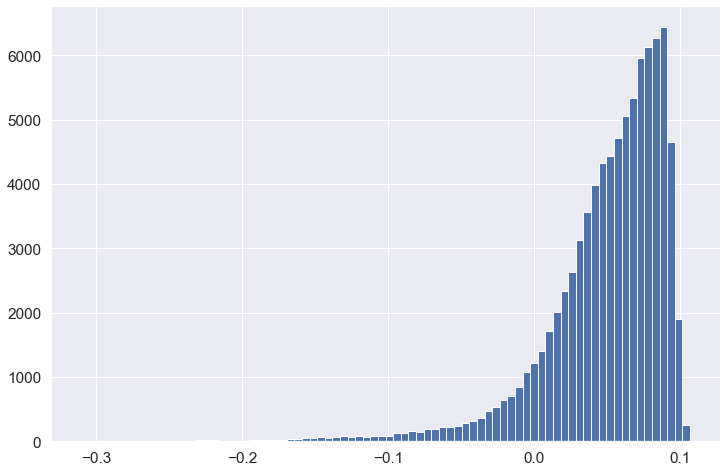

In [14]:
scores = iso_forest.decision_function(X_test)

plt.figure(figsize=(12, 8))
plt.hist(scores, bins=80);
plt.show()

## Fast-MCD (Minimum Covariance Determinant)

Fast-MCD is implemented by Scikit-Learn's EllipticEnvelope class:
https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html

This algorithm is useful for outlier detection, in particular to clean up a dataset. It assumes that the normal instances (inliers) are generated from a single Gaussian distribution (not a mixture). It also assumes that the dataset is contaminated with outliers that were not generated from this Gaussian distribution. When the algorithm estimates the parameters of the Gaussian distribution (i.e., the shape of the elliptic envelope around the inliers), it is careful to ignore the instances that are most likely outliers. This technique gives a better estimation of the elliptic envelope and thus makes the algorithm better at identifying the outliers.

In [15]:
%%time

warnings.filterwarnings('ignore')

t0 = time()
ee = EllipticEnvelope(contamination=0.1,random_state=0, support_fraction=0.1)
ee.fit(X_train)

time_ee = time() - t0

print("Fast-MCD: Running Time = %0.3fs" % time_ee)

Fast-MCD: Running Time = 23.008s
CPU times: user 1min 28s, sys: 3 s, total: 1min 31s
Wall time: 23 s


## Fast-MCD: Evaluate Model Performance


Number of Errors:  8379
Accuracy Score:  0.9019346230820547
AUC Score:  0.8995006099078828


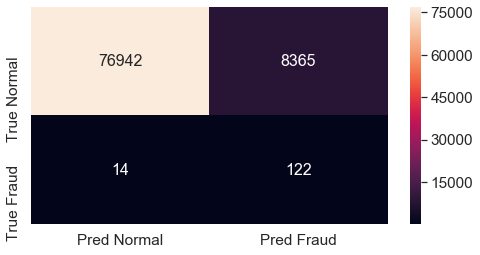

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85307
           1       0.01      0.90      0.03       136

    accuracy                           0.90     85443
   macro avg       0.51      0.90      0.49     85443
weighted avg       1.00      0.90      0.95     85443

CPU times: user 955 ms, sys: 59.3 ms, total: 1.01 s
Wall time: 460 ms


In [16]:
%%time

y_test_pred_ee = ee.predict(X_test)


# Create a copy of the predictions
y_test_pred_ee_class=y_test_pred_ee.copy()

# Re-Label fraudulent transactions with 1 and valid transaction with 0
y_test_pred_ee_class[y_test_pred_ee==-1]=1  # Fraudulent transactions are labelled as 1.
y_test_pred_ee_class[y_test_pred_ee==1]=0   # Valid transactions are labelled as 0.


# Compute total number of errors 
errors_ee = (y_test_pred_ee_class != y_test).sum() 
print("\nNumber of Errors: ", errors_ee)

print("Accuracy Score: ", accuracy_score(y_test_pred_ee_class, y_test))


auc_ee = roc_auc_score(y_test, y_test_pred_ee_class)

print("AUC Score: ", auc_ee)


cf_ee = confusion_matrix(y_test, y_test_pred_ee_class)

df_cm = pd.DataFrame(cf_ee, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.show()

print(classification_report(y_test, y_test_pred_ee_class))

## Gaussian Mixture Model

First, we need to final an optimal $k$. To do this we train GMM with various values of $k$ and measure their Bayesian information criterion (BIC) and Akaike information criterion (AIC).

The optimal $k$ minimizes BIC and AIC.

In [17]:
%%time

neighbors = np.arange(1,21)

gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X_train)
             for k in neighbors]

CPU times: user 16h 38min 23s, sys: 1h 27min 43s, total: 18h 6min 6s
Wall time: 6h 47min 58s


In [18]:
bics = [model.bic(X_train) for model in gms_per_k]
aics = [model.aic(X_train) for model in gms_per_k]

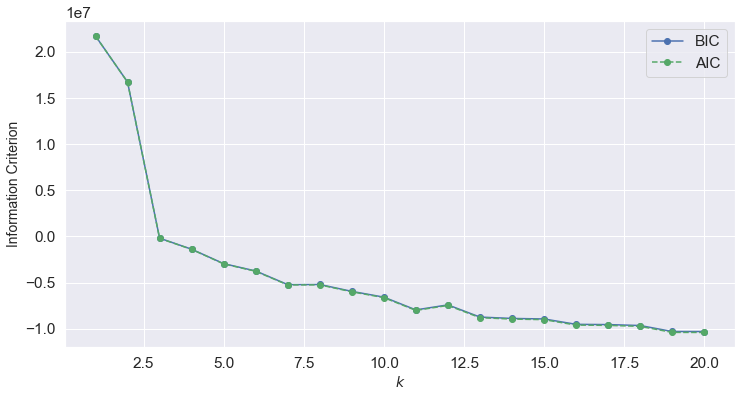

Optimal K:  20


In [21]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), bics, "bo-", label="BIC")
plt.plot(range(1, 21), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.legend()
plt.show()


# Find the value of "k" that gives minimum BIC
j = 0
min_bic = bics[j]
max_k = 1

for i in neighbors:
    if(bics[j] < min_bic):
        min_bic = bics[j]
        max_k = i
    j +=1
    
print("Optimal K: ", max_k)

## GMM: Train using Optimal $k$

In [22]:
%%time

t0 = time()
gmm = GaussianMixture(n_components=max_k, n_init=10, random_state=42)
gmm.fit(X_train)

time_gmm = time() - t0

print("GMM: Running Time = %0.3fs" % time_gmm)

GMM: Running Time = 1864.738s
CPU times: user 1h 31min 24s, sys: 7min 56s, total: 1h 39min 20s
Wall time: 31min 4s


## GMM: Finding Anomalies

To determine whether a data point is an anomaly we need to compute the log-likelihood of the given data.

We use the "score" method of GMM to compute the per-sample average log-likelihood of the data.

Then, compare the likelihood values with the density threshold.

we identify the outliers using the first percentile lowest density as the threshold. I.e., approximately 1% of the instances will be flagged as anomalies.

In [23]:
densities = gmm.score_samples(X_train)
density_threshold = np.percentile(densities, 1)

## GMM: Evaluate Model Performance


Number of Errors:  1776
Accuracy Score:  0.991091671515419
AUC Score:  0.8988011153297886


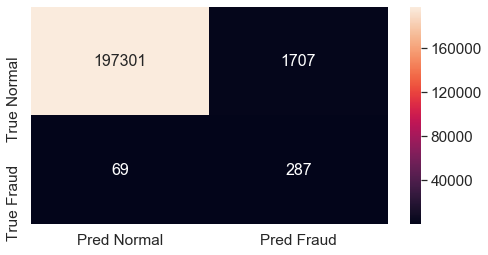

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    199008
           1       0.14      0.81      0.24       356

    accuracy                           0.99    199364
   macro avg       0.57      0.90      0.62    199364
weighted avg       1.00      0.99      0.99    199364



In [24]:
# Create a copy of the predictions
y_train_pred_gmm=y_train.copy()

# Re-Label fraudulent transactions with 1 and valid transaction with 0
y_train_pred_gmm[densities < density_threshold]=1  # Fraudulent transactions are labelled as 1.
y_train_pred_gmm[densities >= density_threshold]=0   # Valid transactions are labelled as 0.


# Compute total number of errors 
errors_gmm = (y_train_pred_gmm != y_train).sum() 
print("\nNumber of Errors: ", errors_gmm)

print("Accuracy Score: ", accuracy_score(y_train_pred_gmm, y_train))


auc_gmm = roc_auc_score(y_train, y_train_pred_gmm)

print("AUC Score: ", auc_gmm)


cf_gmm = confusion_matrix(y_train, y_train_pred_gmm)

df_cm = pd.DataFrame(cf_gmm, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.show()

print(classification_report(y_train, y_train_pred_gmm))

## Comparison of the Four Anomaly Detection Algorithms

In [25]:
data = [["LOF", auc_lof, time_lof],
       ["Isolation Forest", auc_iso_forest, time_iso_forest],
       ["Fast MCD", auc_ee, time_ee],
       ["GMM", auc_gmm, time_gmm]]

pd.DataFrame(data, columns=["Model", "AUC", "Running-Time (s)"])

,Model,AUC,Running-Time (s)
0,LOF,0.700315,0.746932
1,Isolation Forest,0.902866,10.828123
2,Fast MCD,0.899501,23.008117
3,GMM,0.898801,1864.737648


# Observation

We observe that **Isolation Forest is the most efficient** as it achieves the highest AUC score and it is fast.

- Both Fast-MCD and GMM achieve similar AUC score as the Isolation Forest, however their time-complexity is high. 

- GMM requires significantly longer time, excluding the required for optimal selction of $k$.